# Feature Engineering and Stacked Echo State Networks for Musical Onset Detection

In music analysis, one of the most fundamental tasks is note onset detection - detecting
the beginning of new note events. As the target function of onset detection is related to
other tasks, such as beat tracking or tempo estimation, onset detection is the basis for
such related tasks. Furthermore, it can help to improve Automatic Music Transcription
(AMT). Typically, different approaches for onset detection follow a similar outline: An
audio signal is transformed into an Onset Detection Function (ODF), which should have
rather low values (i.e. close to zero) for most of the time but with pronounced peaks at
onset times, which can then be extracted by applying peak picking algorithms on the ODF.
In the recent years, several kinds of neural networks were used successfully to compute
the ODF from feature vectors. Currently, Convolutional Neural Networks (CNNs) define the
state of the art. In this paper, we build up on an alternative approach to obtain a ODF
by Echo State Networks (ESNs), which have achieved comparable results to CNNs in several
tasks, such as speech and image recognition. In contrast to the typical iterative
training procedures of deep learning architectures, such as CNNs or networks consisting
of Long-Short-Term Memory Cells (LSTMs), in ESNs only a very small part of the weights is
easily trained in one shot using linear regression.

At first, we import required Python modules. Then, we start loading the data. 
The dataset can be either downloaded from here or manually downloaded from 
[here](https://drive.google.com/file/d/1ICEfaZ2r_cnqd3FLNC5F_UOEUalgV7cv/view?usp=sharing).

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator, LogLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import madmom

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import make_scorer
from sklearn.utils.fixes import loguniform
from sklearn.base import clone
from scipy.stats import uniform
from scipy.sparse import vstack as sparse_vstack
from dataset import OnsetDataset
from metrics import cosine_distance
from signal_processing import OnsetPreProcessor
from input_to_node import ClusterInputToNode
from model_selection import PredefinedTrainValidationTestSplit
import numpy as np
from joblib import dump, load
import pandas as pd
from itertools import product

from pyrcn.echo_state_network import ESNRegressor
from pyrcn.model_selection import SequentialSearchCV
from pyrcn.base import _uniform_random_weights, _uniform_random_bias

In [2]:
sns.set_theme(context="paper")
sns.set(font="Times New Roman")
%matplotlib inline

After downloading the dataset, please extract it to the `data` directory, which should in the end contain three subdirectories `annotations`, `audio`, `splits`, respectively.

In any case, the `OnsetDataset` object is responsible to providing the dataset. It is initialized with a path to the dataset and optional arguments, such as custom file endings for the different files to be searched for. Importantly, we deal with `.flac` files.

From the dataset class, we load the spectrograms and the target labels in `(X, y)`, where each element is a spectrogram and the corresponding target sequence.

The dataset has a predefined split in training, validation and test folds. To utilize the split, we prepare the `test_fold`, which assigns each input and target sequence to the correct fold.

In [3]:
plot=True
frame_sizes=(2048, )
decoded_frame_sizes = "_".join(map(str, frame_sizes))
num_bands=(6, )

In [4]:
pre_processor = OnsetPreProcessor(frame_sizes=frame_sizes, num_bands=num_bands)
dataset = OnsetDataset(
    path=r"C:\Users\Steiner\Documents\Python\onset_detection\data",
    audio_suffix=".flac")
X, y = dataset.return_X_y(pre_processor=pre_processor)
test_fold = np.zeros(shape=X.shape)
start_idx = 0
for k, fold in enumerate(dataset.folds):
    test_fold[start_idx:start_idx + len(fold)] = k
    start_idx += len(fold)
cv_vali = PredefinedTrainValidationTestSplit(test_fold=test_fold)
cv_test = PredefinedTrainValidationTestSplit(test_fold=test_fold,
                                             validation=False)

In [5]:
X_unlabeled = dataset.return_X(pre_processor=pre_processor)

Visualization of the input spectrograms and the target onset labels

In [ ]:
if plot:
    fig, axs = plt.subplots()
    sns.heatmap(data=X[0].T, ax=axs, square=False, rasterized=True)
    axs.invert_yaxis()
    axs.set_xlabel("Frame index $n$")
    axs.set_ylabel("Feature Index")
    axs.eventplot(positions=dataset.annotations[0]*100, color='w',
                  linestyles=':', linewidth=1, linelengths=X[0].shape[1],
                  lineoffsets=.5*X[0].shape[1], label="Onset")
    axs.xaxis.set_minor_locator(MaxNLocator(20, steps=(10, )))
    axs.yaxis.set_minor_locator(MaxNLocator(20, steps=(10, )))
    axs.legend(loc="upper right")
    plt.savefig(f"../results/input_spectrogram_{decoded_frame_sizes}_with_targets.pdf", bbox_inches='tight', pad_inches=0)

We optimize a model using a sequence of random searches. The target for the optimization is to maximize the cross correlation between the computed output and the ground truth output. This randomized approach is slightly different from the grid search described in the paper. Consequently, the resulting hyper-parameters are slightly better, and the results will also be slightly different. However, the main outline is still the same.

In [ ]:
initial_esn_params = {
    'hidden_layer_size': 50, 'k_in': 10, 'input_scaling': 0.4,
    'input_activation': 'identity', 'bias_scaling': 0.0,
    'spectral_radius': 0.0, 'leakage': 1.0, 'k_rec': 10,
    'reservoir_activation': 'tanh', 'bidirectional': False,
    'alpha': 1e-5, 'random_state': 42}

base_esn = ESNRegressor(**initial_esn_params)
# Run model selection
step1_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                'spectral_radius': uniform(loc=0, scale=2)}
step2_params = {'leakage': uniform(loc=1e-2, scale=1.0)}
step3_params = {'bias_scaling': uniform(loc=0, scale=2)}

kwargs_step1 = {
    'n_iter': 200, 'random_state': 42, 'verbose': 10, 'n_jobs': -1,
    'scoring': make_scorer(cosine_distance, greater_is_better=False),
    "cv": cv_vali}
kwargs_step2 = {
    'n_iter': 50, 'random_state': 42, 'verbose': 10, 'n_jobs': -1,
    'scoring': make_scorer(cosine_distance, greater_is_better=False),
    "cv": cv_vali}
kwargs_step3 = {
    'n_iter': 50, 'random_state': 42, 'verbose': 10, 'n_jobs': -1,
    'scoring': make_scorer(cosine_distance, greater_is_better=False),
    "cv": cv_vali}

searches = [
    ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
    ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
    ('step3', RandomizedSearchCV, step3_params, kwargs_step3)]

try:
    search = load(f'../results/sequential_search_basic_esn_'
                  f'{decoded_frame_sizes}.joblib')
except FileNotFoundError:
    search = SequentialSearchCV(base_esn, searches=searches).fit(X, y)
    dump(search, f'../results/sequential_search_basic_esn_'
                 f'{decoded_frame_sizes}.joblib')

In [7]:
search.all_best_params_

{'step1': {'input_scaling': 0.6164290596595899,
  'spectral_radius': 0.018394103233259296},
 'step2': {'leakage': 0.9661761457749352},
 'step3': {'bias_scaling': 0.041168988591604894}}

Visualization of the random search across input scaling and spectral radius

In [ ]:
if plot:
    df = pd.DataFrame(search.all_cv_results_["step1"])
    df["mean_test_score"] = -df["mean_test_score"]
    fig, axs = plt.subplots()
    sns.scatterplot(data=df, x="param_spectral_radius", y="param_input_scaling",
                    hue="mean_test_score", ax=axs, palette="RdBu")
    
    norm = plt.Normalize(df["mean_test_score"].min(), df["mean_test_score"].max())
    sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    sm.set_array([])
    axs.set_xlim((0, 2.05))
    axs.set_ylim((0, 1.05))
    axs.set_xlabel("Spectral radius")
    axs.set_ylabel("Input scaling")
    # Remove the legend and add a colorbar
    axs.get_legend().remove()
    axs.figure.colorbar(sm)
    plt.savefig(f"../results/basic_esn_{decoded_frame_sizes}_is_sr.pdf", bbox_inches='tight', pad_inches=0)

Visualization of the random search across the leakage

In [ ]:
if plot:
    df = pd.DataFrame(search.all_cv_results_["step2"])
    df["mean_test_score"] = -df["mean_test_score"]
    fig, axs = plt.subplots()
    sns.lineplot(data=df, x="param_leakage", y="mean_test_score", ax=axs)
    axs.set_xlim((0.0, 1.0))
    axs.set_xlabel("Leakage")
    axs.set_ylabel("Correlation")
    plt.savefig(f"../results/basic_esn_{decoded_frame_sizes}_leakage.pdf", bbox_inches='tight', pad_inches=0)

Visualization of the random search across the bias scaling

In [ ]:
if plot:
    df = pd.DataFrame(search.all_cv_results_["step3"])
    df["mean_test_score"] = -df["mean_test_score"]
    fig, axs = plt.subplots()
    sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score", ax=axs)
    axs.set_xlim((0.0, 1.0))
    axs.set_xlabel("Bias scaling")
    axs.set_ylabel("Correlation")
    plt.savefig(f"../results/basic_esn_{decoded_frame_sizes}_bias.pdf", bbox_inches='tight', pad_inches=0)

Next, we fit models with increased reservoir sizes and an optional bidirectional mode. For each configuration, we optimize the regularization parameter.

One model for each fold is fitted to stay in line with the reference publications.

In [ ]:
initial_esn_params = {
    'hidden_layer_size': 50, 'k_in': 10, 'input_scaling': 0.4,
    'input_activation': 'identity', 'bias_scaling': 0.0,
    'spectral_radius': 0.0, 'leakage': 1.0, 'k_rec': 10,
    'reservoir_activation': 'tanh', 'bidirectional': False,
    'alpha': 1e-5, 'random_state': 42}

base_esn = ESNRegressor(input_to_node=ClusterInputToNode(),
                        **initial_esn_params)
# Run model selection
step1_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                'spectral_radius': uniform(loc=0, scale=2)}
step2_params = {'leakage': uniform(loc=1e-2, scale=1.0)}
step3_params = {'bias_scaling': uniform(loc=0, scale=2)}

kwargs_step1 = {
    'n_iter': 200, 'random_state': 42, 'verbose': 10, 'n_jobs': -1,
    'scoring': make_scorer(cosine_distance, greater_is_better=False),
    "cv": cv_vali}
kwargs_step2 = {
    'n_iter': 50, 'random_state': 42, 'verbose': 10, 'n_jobs': -1,
    'scoring': make_scorer(cosine_distance, greater_is_better=False),
    "cv": cv_vali}
kwargs_step3 = {
    'n_iter': 50, 'random_state': 42, 'verbose': 10, 'n_jobs': -1,
    'scoring': make_scorer(cosine_distance, greater_is_better=False),
    "cv": cv_vali}

searches = [
    ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
    ('step2', RandomizedSearchCV, step2_params, kwargs_step2),
    ('step3', RandomizedSearchCV, step3_params, kwargs_step3)]

try:
    search = load(f'../results/sequential_search_kmeans_esn_'
                  f'{decoded_frame_sizes}.joblib')
except FileNotFoundError:
    search = SequentialSearchCV(base_esn, searches=searches).fit(X, y)
    dump(search, f'../results/sequential_search_kmeans_esn_'
                 f'{decoded_frame_sizes}.joblib')

In [8]:
search.all_best_params_

{'step1': {'input_scaling': 0.04050024993904943,
  'spectral_radius': 0.07469637749842883},
 'step2': {'leakage': 0.7842330265121569},
 'step3': {'bias_scaling': 0.31203728088487304}}

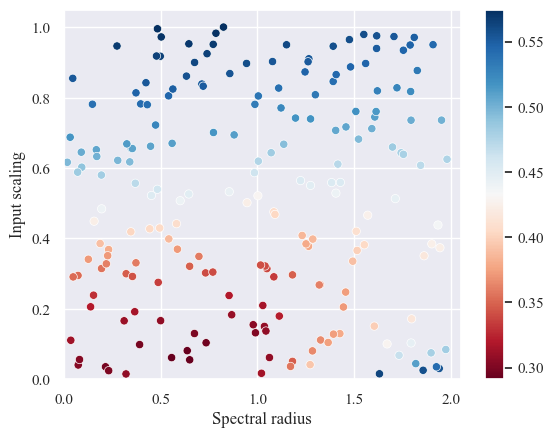

In [14]:
if plot:
    df = pd.DataFrame(search.all_cv_results_["step1"])
    df["mean_test_score"] = -df["mean_test_score"]
    fig, axs = plt.subplots()
    sns.scatterplot(data=df, x="param_spectral_radius", y="param_input_scaling",
                    hue="mean_test_score", ax=axs, palette="RdBu")
    
    norm = plt.Normalize(df["mean_test_score"].min(), df["mean_test_score"].max())
    sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    sm.set_array([])
    axs.set_xlim((0, 2.05))
    axs.set_ylim((0, 1.05))
    axs.set_xlabel("Spectral radius")
    axs.set_ylabel("Input scaling")
    # Remove the legend and add a colorbar
    axs.get_legend().remove()
    axs.figure.colorbar(sm)
    plt.savefig(f"../results/kmeans_esn_{decoded_frame_sizes}_is_sr.pdf", bbox_inches='tight', pad_inches=0)

Visualization of the random search across the leakage

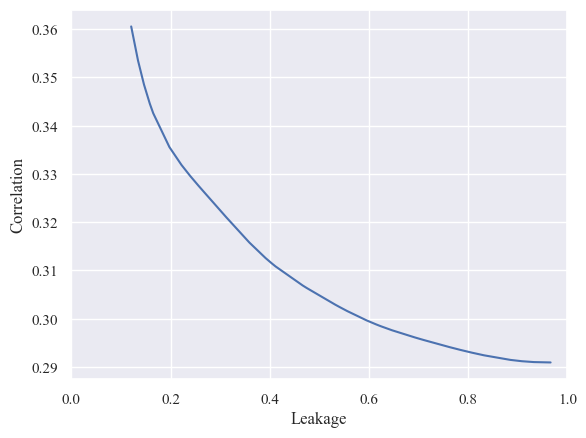

In [15]:
if plot:
    df = pd.DataFrame(search.all_cv_results_["step2"])
    df["mean_test_score"] = -df["mean_test_score"]
    fig, axs = plt.subplots()
    sns.lineplot(data=df, x="param_leakage", y="mean_test_score", ax=axs)
    axs.set_xlim((0.0, 1.0))
    axs.set_xlabel("Leakage")
    axs.set_ylabel("Correlation")
    plt.savefig(f"../results/kmeans_esn_{decoded_frame_sizes}_leakage.pdf", bbox_inches='tight', pad_inches=0)

Visualization of the random search across the bias scaling

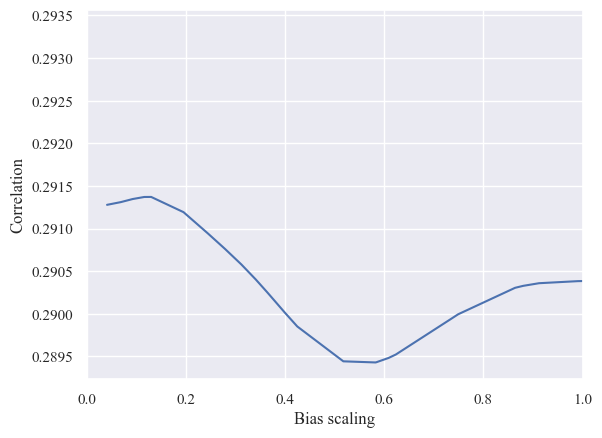

In [16]:
if plot:
    df = pd.DataFrame(search.all_cv_results_["step3"])
    df["mean_test_score"] = -df["mean_test_score"]
    fig, axs = plt.subplots()
    sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score", ax=axs)
    axs.set_xlim((0.0, 1.0))
    axs.set_xlabel("Bias scaling")
    axs.set_ylabel("Correlation")
    plt.savefig(f"../results/kmeans_esn_{decoded_frame_sizes}_bias.pdf", bbox_inches='tight', pad_inches=0)

In [17]:
kwargs_final = {
    'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1,
    'scoring': make_scorer(cosine_distance, greater_is_better=False)}
param_distributions_final = {'alpha': loguniform(1e-5, 1e1)}
hidden_layer_sizes = (
    50, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600)
bi_directional = (False, True)
thresholds = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)

In [18]:
for hidden_layer_size, bidirectional in product(
        hidden_layer_sizes, bi_directional):
    params = {"hidden_layer_size": hidden_layer_size, 
              "bidirectional": bidirectional}
    for k, (train_index, vali_index) in enumerate(cv_vali.split()):
        test_fold = np.zeros(
            shape=(len(train_index) + len(vali_index), ), dtype=int)
        test_fold[:len(train_index)] = -1
        ps = PredefinedSplit(test_fold=test_fold)
        try:
            esn = load(f"../results/km_esn_{decoded_frame_sizes}_"
                       f"{hidden_layer_size}_{bidirectional}_{k}.joblib")
            print(esn.best_estimator_.regressor.alpha)
        except FileNotFoundError:
            break
            esn = RandomizedSearchCV(
                estimator=clone(search.best_estimator_).set_params(
                    **params), cv=ps,
                param_distributions=param_distributions_final,
                **kwargs_final).fit(
                X[np.hstack((train_index, vali_index))],
                y[np.hstack((train_index, vali_index))])
            dump(esn, f"../results/km_esn_{decoded_frame_sizes}_"
                      f"{hidden_layer_size}_{bidirectional}_{k}.joblib")

0.0001577766363058246
0.0006690421166498799
0.044184415211997216
0.0017670169402947947
0.0005589524205217922
0.0015782327810795582
0.0006690421166498799
0.0003570095960030949


Finally, we export our results if desired.

In [19]:
def evaluate_onsets(predictions, annotations):
    evals = []
    for ann, det in zip(annotations, predictions):
        e = madmom.evaluation.onsets.OnsetEvaluation(
            det, ann, combine=0.03, window=0.025)
        evals.append(e)
    se = madmom.evaluation.onsets.OnsetSumEvaluation(evals)
    me = madmom.evaluation.onsets.OnsetMeanEvaluation(evals)
    return se, me

In [20]:
try:
    df_results = pd.read_pickle(f"../results/scores_km_{decoded_frame_sizes}.pkl")
except FileNotFoundError:
    columns = [
        "param_hidden_layer_size", "param_bidirectional", "param_threshold",
        "params",
        "split0_avg_test_score", "split1_avg_test_score",
        "split2_avg_test_score", "split3_avg_test_score", 
        "split4_avg_test_score", "split5_avg_test_score",
        "split6_avg_test_score", "split7_avg_test_score",
        "split0_sum_test_score", "split1_sum_test_score",
        "split2_sum_test_score", "split3_sum_test_score", 
        "split4_sum_test_score", "split5_sum_test_score",
        "split6_sum_test_score", "split7_sum_test_score",
        "split0_avg_train_score", "split1_avg_train_score",
        "split2_avg_train_score", "split3_avg_train_score", 
        "split4_avg_train_score", "split5_avg_train_score",
        "split6_avg_train_score", "split7_avg_train_score",
        "split0_sum_train_score", "split1_sum_train_score",
        "split2_sum_train_score", "split3_sum_train_score", 
        "split4_sum_train_score", "split5_sum_train_score",
        "split6_sum_train_score", "split7_sum_train_score",
        "mean_avg_test_score", "mean_sum_test_score",
        "mean_avg_train_score", "mean_sum_train_score",
        "std_avg_test_score", "std_sum_test_score",
        "std_avg_train_score", "std_sum_train_score"]
    df_results = pd.DataFrame(columns=columns)
    df_results[
        ["param_hidden_layer_size", "param_bidirectional", "param_threshold",
         "params"]] = [[hidden_layer_size, bidirectional, threshold,
                        {"hidden_layer_size": hidden_layer_size,
                         "bidirectional": bidirectional,
                         "threshold": threshold}]
                       for hidden_layer_size, bidirectional, threshold in 
                       product(hidden_layer_sizes, bi_directional, thresholds)]

In [21]:
df_results.head(n=194)

,param_hidden_layer_size,param_bidirectional,param_threshold,params,split0_avg_test_score,split1_avg_test_score,split2_avg_test_score,split3_avg_test_score,split4_avg_test_score,split5_avg_test_score,...,split6_sum_train_score,split7_sum_train_score,mean_avg_test_score,mean_sum_test_score,mean_avg_train_score,mean_sum_train_score,std_avg_test_score,std_sum_test_score,std_avg_train_score,std_sum_train_score
0,50,False,0.1,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 32.07 F...,mean for 41 files\n Onsets: 35.41 TP: 31.51 F...,mean for 39 files\n Onsets: 57.28 TP: 50.03 F...,mean for 40 files\n Onsets: 84.17 TP: 70.30 F...,mean for 40 files\n Onsets: 101.58 TP: 94.30 ...,mean for 40 files\n Onsets: 54.20 TP: 49.05 F...,...,sum for 281 files\n Onsets: 18967 TP: 17002 F...,sum for 281 files\n Onsets: 21547 TP: 18887 F...,"{'Precision': 0.465375, 'Recall': 0.886125, 'F...","{'Precision': 0.4293449248837032, 'Recall': 0....","{'Precision': 0.46487500000000004, 'Recall': 0...","{'Precision': 0.43028748126443145, 'Recall': 0...",NaN,NaN,NaN,NaN
1,50,False,0.2,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 31.80 F...,mean for 41 files\n Onsets: 35.41 TP: 30.90 F...,mean for 39 files\n Onsets: 57.28 TP: 49.46 F...,mean for 40 files\n Onsets: 84.17 TP: 68.97 F...,mean for 40 files\n Onsets: 101.58 TP: 92.78 ...,mean for 40 files\n Onsets: 54.20 TP: 48.70 F...,...,sum for 281 files\n Onsets: 18967 TP: 16662 F...,sum for 281 files\n Onsets: 21547 TP: 18274 F...,"{'Precision': 0.561875, 'Recall': 0.87225, 'F-...","{'Precision': 0.5402910111529655, 'Recall': 0....","{'Precision': 0.572, 'Recall': 0.8718750000000...","{'Precision': 0.550399198049155, 'Recall': 0.8...",NaN,NaN,NaN,NaN
2,50,False,0.3,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 31.05 F...,mean for 41 files\n Onsets: 35.41 TP: 29.51 F...,mean for 39 files\n Onsets: 57.28 TP: 47.74 F...,mean for 40 files\n Onsets: 84.17 TP: 66.92 F...,mean for 40 files\n Onsets: 101.58 TP: 89.30 ...,mean for 40 files\n Onsets: 54.20 TP: 47.80 F...,...,sum for 281 files\n Onsets: 18967 TP: 15845 F...,sum for 281 files\n Onsets: 21547 TP: 17247 F...,"{'Precision': 0.705875, 'Recall': 0.84075, 'F-...","{'Precision': 0.7038276864813687, 'Recall': 0....","{'Precision': 0.7113749999999999, 'Recall': 0....","{'Precision': 0.7057809037479525, 'Recall': 0....",NaN,NaN,NaN,NaN
3,50,False,0.4,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 29.73 F...,mean for 41 files\n Onsets: 35.41 TP: 27.22 F...,mean for 39 files\n Onsets: 57.28 TP: 45.05 F...,mean for 40 files\n Onsets: 84.17 TP: 62.67 F...,mean for 40 files\n Onsets: 101.58 TP: 82.88 ...,mean for 40 files\n Onsets: 54.20 TP: 45.25 F...,...,sum for 281 files\n Onsets: 18967 TP: 14636 F...,sum for 281 files\n Onsets: 21547 TP: 15880 F...,"{'Precision': 0.818125, 'Recall': 0.7867500000...","{'Precision': 0.8381348511383537, 'Recall': 0....","{'Precision': 0.8223750000000001, 'Recall': 0....","{'Precision': 0.8363732045567113, 'Recall': 0....",NaN,NaN,NaN,NaN
4,50,False,0.5,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 27.85 F...,mean for 41 files\n Onsets: 35.41 TP: 24.12 F...,mean for 39 files\n Onsets: 57.28 TP: 42.18 F...,mean for 40 files\n Onsets: 84.17 TP: 57.45 F...,mean for 40 files\n Onsets: 101.58 TP: 75.03 ...,mean for 40 files\n Onsets: 54.20 TP: 42.73 F...,...,sum for 281 files\n Onsets: 18967 TP: 13325 F...,sum for 281 files\n Onsets: 21547 TP: 14274 F...,"{'Precision': 0.891875, 'Recall': 0.72, 'F-mea...","{'Precision': 0.9134589999471989, 'Recall': 0....","{'Precision': 0.891, 'Recall': 0.71625, 'F-mea...","{'Precision': 0.9144564168903712, 'Recall': 0....",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,25600,False,1.0,"{'hidden_layer_size': 25600, 'bidirectional': 

In [22]:
for hidden_layer_size, bidirectional in product(
        hidden_layer_sizes, bi_directional):
    params = {"hidden_layer_size": hidden_layer_size,
              "bidirectional": bidirectional}
    print(hidden_layer_size, bidirectional)
    for k, (train_index, test_index) in enumerate(cv_test.split()):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        try:
            esn = load(f"../results/km_esn_{decoded_frame_sizes}_"
                       f"{hidden_layer_size}_{bidirectional}_{k}.joblib")
        except FileNotFoundError:
            continue
        y_train_pred = esn.predict(X_train)
        y_test_pred = esn.predict(X_test)
        for thr in thresholds:
            rnn_peak_picking = \
                madmom.features.onsets.OnsetPeakPickingProcessor(
                    threshold=thr, pre_max=0.01, post_max=0.01,
                    smooth=0.07, combine=0.03)
            detections = [rnn_peak_picking(act) for act in y_train_pred]
            annotations = [
                ann for ann in np.asarray(
                    dataset.annotations, dtype=object)[train_index]]
            se, me = evaluate_onsets(detections, annotations)
            df_results.loc[
                (df_results['param_hidden_layer_size'] == hidden_layer_size) &
                (df_results['param_bidirectional'] == bidirectional) &
                (df_results['param_threshold'] == thr), f"split{k}_avg_train_score"] = me.tostring()
            df_results.loc[
                (df_results['param_hidden_layer_size'] == hidden_layer_size) &
                (df_results['param_bidirectional'] == bidirectional) &
                (df_results['param_threshold'] == thr), f"split{k}_sum_train_score"] = se.tostring()
            detections = [rnn_peak_picking(act) for act in y_test_pred]
            annotations = [
                ann for ann in np.asarray(
                    dataset.annotations, dtype=object)[test_index]]
            se, me = evaluate_onsets(detections, annotations)
            df_results.loc[
                (df_results['param_hidden_layer_size'] == hidden_layer_size) &
                (df_results['param_bidirectional'] == bidirectional) &
                (df_results['param_threshold'] == thr), f"split{k}_avg_test_score"] = me.tostring()
            df_results.loc[
                (df_results['param_hidden_layer_size'] == hidden_layer_size) &
                (df_results['param_bidirectional'] == bidirectional) &
                (df_results['param_threshold'] == thr), f"split{k}_sum_test_score"] = se.tostring()
            df_results.to_pickle(f"../results/scores_km_{decoded_frame_sizes}.pkl")

50 False
50 True
100 False
100 True
200 False
200 True
400 False
400 True
800 False
800 True
1600 False
1600 True
3200 False
3200 True
6400 False
6400 True
12800 False
12800 True
25600 False
25600 True


In [23]:
df_results.head(n=110)

,param_hidden_layer_size,param_bidirectional,param_threshold,params,split0_avg_test_score,split1_avg_test_score,split2_avg_test_score,split3_avg_test_score,split4_avg_test_score,split5_avg_test_score,...,split6_sum_train_score,split7_sum_train_score,mean_avg_test_score,mean_sum_test_score,mean_avg_train_score,mean_sum_train_score,std_avg_test_score,std_sum_test_score,std_avg_train_score,std_sum_train_score
0,50,False,0.1,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 32.07 F...,mean for 41 files\n Onsets: 35.41 TP: 31.51 F...,mean for 39 files\n Onsets: 57.28 TP: 50.03 F...,mean for 40 files\n Onsets: 84.17 TP: 70.30 F...,mean for 40 files\n Onsets: 101.58 TP: 94.30 ...,mean for 40 files\n Onsets: 54.20 TP: 49.05 F...,...,sum for 281 files\n Onsets: 18967 TP: 17002 F...,sum for 281 files\n Onsets: 21547 TP: 18887 F...,"{'Precision': 0.465375, 'Recall': 0.886125, 'F...","{'Precision': 0.4293449248837032, 'Recall': 0....","{'Precision': 0.46487500000000004, 'Recall': 0...","{'Precision': 0.43028748126443145, 'Recall': 0...",NaN,NaN,NaN,NaN
1,50,False,0.2,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 31.80 F...,mean for 41 files\n Onsets: 35.41 TP: 30.90 F...,mean for 39 files\n Onsets: 57.28 TP: 49.46 F...,mean for 40 files\n Onsets: 84.17 TP: 68.97 F...,mean for 40 files\n Onsets: 101.58 TP: 92.78 ...,mean for 40 files\n Onsets: 54.20 TP: 48.70 F...,...,sum for 281 files\n Onsets: 18967 TP: 16662 F...,sum for 281 files\n Onsets: 21547 TP: 18274 F...,"{'Precision': 0.561875, 'Recall': 0.87225, 'F-...","{'Precision': 0.5402910111529655, 'Recall': 0....","{'Precision': 0.572, 'Recall': 0.8718750000000...","{'Precision': 0.550399198049155, 'Recall': 0.8...",NaN,NaN,NaN,NaN
2,50,False,0.3,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 31.05 F...,mean for 41 files\n Onsets: 35.41 TP: 29.51 F...,mean for 39 files\n Onsets: 57.28 TP: 47.74 F...,mean for 40 files\n Onsets: 84.17 TP: 66.92 F...,mean for 40 files\n Onsets: 101.58 TP: 89.30 ...,mean for 40 files\n Onsets: 54.20 TP: 47.80 F...,...,sum for 281 files\n Onsets: 18967 TP: 15845 F...,sum for 281 files\n Onsets: 21547 TP: 17247 F...,"{'Precision': 0.705875, 'Recall': 0.84075, 'F-...","{'Precision': 0.7038276864813687, 'Recall': 0....","{'Precision': 0.7113749999999999, 'Recall': 0....","{'Precision': 0.7057809037479525, 'Recall': 0....",NaN,NaN,NaN,NaN
3,50,False,0.4,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 29.73 F...,mean for 41 files\n Onsets: 35.41 TP: 27.22 F...,mean for 39 files\n Onsets: 57.28 TP: 45.05 F...,mean for 40 files\n Onsets: 84.17 TP: 62.67 F...,mean for 40 files\n Onsets: 101.58 TP: 82.88 ...,mean for 40 files\n Onsets: 54.20 TP: 45.25 F...,...,sum for 281 files\n Onsets: 18967 TP: 14636 F...,sum for 281 files\n Onsets: 21547 TP: 15880 F...,"{'Precision': 0.818125, 'Recall': 0.7867500000...","{'Precision': 0.8381348511383537, 'Recall': 0....","{'Precision': 0.8223750000000001, 'Recall': 0....","{'Precision': 0.8363732045567113, 'Recall': 0....",NaN,NaN,NaN,NaN
4,50,False,0.5,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 27.85 F...,mean for 41 files\n Onsets: 35.41 TP: 24.12 F...,mean for 39 files\n Onsets: 57.28 TP: 42.18 F...,mean for 40 files\n Onsets: 84.17 TP: 57.45 F...,mean for 40 files\n Onsets: 101.58 TP: 75.03 ...,mean for 40 files\n Onsets: 54.20 TP: 42.73 F...,...,sum for 281 files\n Onsets: 18967 TP: 13325 F...,sum for 281 files\n Onsets: 21547 TP: 14274 F...,"{'Precision': 0.891875, 'Recall': 0.72, 'F-mea...","{'Precision': 0.9134589999471989, 'Recall': 0....","{'Precision': 0.891, 'Recall': 0.71625, 'F-mea...","{'Precision': 0.9144564168903712, 'Recall': 0....",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,1600,False,0.6,"{'hidden_layer_size': 1600, 'bidirectional': F.

In [24]:
def grouped(iterable, n):
    "s -> (s0,s1,s2,...sn-1), (sn,sn+1,sn+2,...s2n-1), (s2n,s2n+1,s2n+2,...s3n-1), ..."
    return zip(*[iter(iterable)]*n)

In [25]:
dict(grouped(df_results["split4_sum_test_score"][194].split()[4:-5], 2))

AttributeError: 'float' object has no attribute 'split'

In [26]:
for index, row in df_results.iterrows():
    tmp_dict = [{key: float(value) for key, value in grouped(row[f"split{fold}_sum_test_score"].split()[4:-5], 2)} for fold in range(8)]
    TP = sum([tmp_dict[fold]["TP:"] for fold in range(8)])
    FP = sum([tmp_dict[fold]["FP:"] for fold in range(8)])
    FN = sum([tmp_dict[fold]["FN:"] for fold in range(8)])
    df_results["mean_sum_test_score"][index] = {"Precision": TP / (TP + FP), "Recall": TP / (TP + FN), "F-measure": 2*TP / (2*TP + FP + FN)}
    tmp_dict = [{key: float(value) for key, value in grouped(row[f"split{fold}_avg_test_score"].split()[4:-5], 2)} for fold in range(8)]
    df_results["mean_avg_test_score"][index] = {"Precision": np.mean([tmp_dict[fold]["Precision:"] for fold in range(8)]),
                                                "Recall": np.mean([tmp_dict[fold]["Recall:"] for fold in range(8)]),
                                                "F-measure": np.mean([tmp_dict[fold]["F-measure:"] for fold in range(8)])}
    tmp_dict = [{key: float(value) for key, value in grouped(row[f"split{fold}_sum_train_score"].split()[4:-5], 2)} for fold in range(8)]
    TP = sum([tmp_dict[fold]["TP:"] for fold in range(8)])
    FP = sum([tmp_dict[fold]["FP:"] for fold in range(8)])
    FN = sum([tmp_dict[fold]["FN:"] for fold in range(8)])
    df_results["mean_sum_train_score"][index] = {"Precision": TP / (TP + FP), "Recall": TP / (TP + FN), "F-measure": 2*TP / (2*TP + FP + FN)}
    tmp_dict = [{key: float(value) for key, value in grouped(row[f"split{fold}_avg_train_score"].split()[4:-5], 2)} for fold in range(8)]
    df_results["mean_avg_train_score"][index] = {"Precision": np.mean([tmp_dict[fold]["Precision:"] for fold in range(8)]),
                                                "Recall": np.mean([tmp_dict[fold]["Recall:"] for fold in range(8)]),
                                                "F-measure": np.mean([tmp_dict[fold]["F-measure:"] for fold in range(8)])}

AttributeError: 'float' object has no attribute 'split'

In [27]:
df_results.to_pickle(f"../results/scores_km_{decoded_frame_sizes}.pkl")

In [28]:
df_results

,param_hidden_layer_size,param_bidirectional,param_threshold,params,split0_avg_test_score,split1_avg_test_score,split2_avg_test_score,split3_avg_test_score,split4_avg_test_score,split5_avg_test_score,...,split6_sum_train_score,split7_sum_train_score,mean_avg_test_score,mean_sum_test_score,mean_avg_train_score,mean_sum_train_score,std_avg_test_score,std_sum_test_score,std_avg_train_score,std_sum_train_score
0,50,False,0.1,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 32.07 F...,mean for 41 files\n Onsets: 35.41 TP: 31.51 F...,mean for 39 files\n Onsets: 57.28 TP: 50.03 F...,mean for 40 files\n Onsets: 84.17 TP: 70.30 F...,mean for 40 files\n Onsets: 101.58 TP: 94.30 ...,mean for 40 files\n Onsets: 54.20 TP: 49.05 F...,...,sum for 281 files\n Onsets: 18967 TP: 17002 F...,sum for 281 files\n Onsets: 21547 TP: 18887 F...,"{'Precision': 0.465375, 'Recall': 0.886125, 'F...","{'Precision': 0.4293449248837032, 'Recall': 0....","{'Precision': 0.46487500000000004, 'Recall': 0...","{'Precision': 0.43028748126443145, 'Recall': 0...",NaN,NaN,NaN,NaN
1,50,False,0.2,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 31.80 F...,mean for 41 files\n Onsets: 35.41 TP: 30.90 F...,mean for 39 files\n Onsets: 57.28 TP: 49.46 F...,mean for 40 files\n Onsets: 84.17 TP: 68.97 F...,mean for 40 files\n Onsets: 101.58 TP: 92.78 ...,mean for 40 files\n Onsets: 54.20 TP: 48.70 F...,...,sum for 281 files\n Onsets: 18967 TP: 16662 F...,sum for 281 files\n Onsets: 21547 TP: 18274 F...,"{'Precision': 0.561875, 'Recall': 0.87225, 'F-...","{'Precision': 0.5402910111529655, 'Recall': 0....","{'Precision': 0.572, 'Recall': 0.8718750000000...","{'Precision': 0.550399198049155, 'Recall': 0.8...",NaN,NaN,NaN,NaN
2,50,False,0.3,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 31.05 F...,mean for 41 files\n Onsets: 35.41 TP: 29.51 F...,mean for 39 files\n Onsets: 57.28 TP: 47.74 F...,mean for 40 files\n Onsets: 84.17 TP: 66.92 F...,mean for 40 files\n Onsets: 101.58 TP: 89.30 ...,mean for 40 files\n Onsets: 54.20 TP: 47.80 F...,...,sum for 281 files\n Onsets: 18967 TP: 15845 F...,sum for 281 files\n Onsets: 21547 TP: 17247 F...,"{'Precision': 0.705875, 'Recall': 0.84075, 'F-...","{'Precision': 0.7038276864813687, 'Recall': 0....","{'Precision': 0.7113749999999999, 'Recall': 0....","{'Precision': 0.7057809037479525, 'Recall': 0....",NaN,NaN,NaN,NaN
3,50,False,0.4,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 29.73 F...,mean for 41 files\n Onsets: 35.41 TP: 27.22 F...,mean for 39 files\n Onsets: 57.28 TP: 45.05 F...,mean for 40 files\n Onsets: 84.17 TP: 62.67 F...,mean for 40 files\n Onsets: 101.58 TP: 82.88 ...,mean for 40 files\n Onsets: 54.20 TP: 45.25 F...,...,sum for 281 files\n Onsets: 18967 TP: 14636 F...,sum for 281 files\n Onsets: 21547 TP: 15880 F...,"{'Precision': 0.818125, 'Recall': 0.7867500000...","{'Precision': 0.8381348511383537, 'Recall': 0....","{'Precision': 0.8223750000000001, 'Recall': 0....","{'Precision': 0.8363732045567113, 'Recall': 0....",NaN,NaN,NaN,NaN
4,50,False,0.5,"{'hidden_layer_size': 50, 'bidirectional': Fal...",mean for 41 files\n Onsets: 34.22 TP: 27.85 F...,mean for 41 files\n Onsets: 35.41 TP: 24.12 F...,mean for 39 files\n Onsets: 57.28 TP: 42.18 F...,mean for 40 files\n Onsets: 84.17 TP: 57.45 F...,mean for 40 files\n Onsets: 101.58 TP: 75.03 ...,mean for 40 files\n Onsets: 54.20 TP: 42.73 F...,...,sum for 281 files\n Onsets: 18967 TP: 13325 F...,sum for 281 files\n Onsets: 21547 TP: 14274 F...,"{'Precision': 0.891875, 'Recall': 0.72, 'F-mea...","{'Precision': 0.9134589999471989, 'Recall': 0....","{'Precision': 0.891, 'Recall': 0.71625, 'F-mea...","{'Precision': 0.9144564168903712, 'Recall': 0....",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,25600,True,0.6,"{'hidden_layer_size': 25600, 'bidirectional': .

In [29]:
df = pd.DataFrame(columns=["Hidden layer size", "Bidirectional", "Threshold", "Precision", "Recall", "F-measure"])

for index, row in df_results.iterrows():
    new_df = pd.DataFrame({"Hidden layer size": [row["param_hidden_layer_size"]],
                           "Bidirectional": [row["param_bidirectional"]],
                           "Threshold": [row["param_threshold"]],
                           "Precision": [row["mean_sum_test_score"]["Precision"]],
                           "Recall": [row["mean_sum_test_score"]["Recall"]],
                           "F-measure": [row["mean_avg_test_score"]["F-measure"]]})
    df = pd.concat([df, new_df])

TypeError: 'float' object is not subscriptable

In [30]:
df = df.groupby(by=["Hidden layer size", "Bidirectional"]).agg({'F-measure':'max'}).reset_index()
df

,Hidden layer size,Bidirectional,F-measure
0,50,False,0.787625
1,50,True,0.799250
2,100,False,0.802375
3,100,True,0.813125
4,200,False,0.817125
5,200,True,0.822125
6,400,False,0.823000
7,400,True,0.832375
8,800,False,0.831250
9,800,True,0.837750


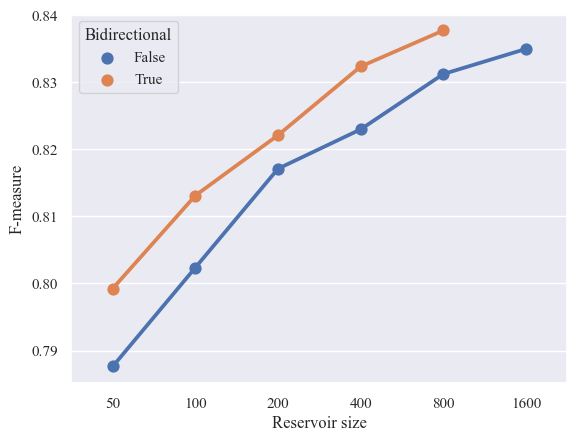

In [31]:
fig, axs = plt.subplots()

sns.pointplot(data=df, x="Hidden layer size", y="F-measure", hue="Bidirectional", errorbar=None, ax=axs)
axs.set_xlabel("Reservoir size")
plt.savefig(f"f_score_km_{decoded_frame_sizes}.pdf", bbox_inches='tight', pad_inches=0)

In [ ]:
all_dfs = [pd.read_pickle(f"../results/scores_{frame_size}.pkl") for frame_size in (1024, 2048, 4096, "1024_2048_4096")]
all_dfs = pd.concat(all_dfs)

In [ ]:
all_dfs["param_window_size"] = ["1024"]*200 + ["2048"]*200 + ["4096"]*200 + ["comb."]*200

In [ ]:
all_dfs = all_dfs.drop(all_dfs[all_dfs.param_bidirectional == True].index)

In [ ]:
df = pd.DataFrame(columns=["Hidden layer size", "Window size", "Bidirectional", "Threshold", "Precision", "Recall", "F-measure"])

for index, row in all_dfs.iterrows():
    new_df = pd.DataFrame({"Hidden layer size": [row["param_hidden_layer_size"]],
                           "Window size": [row["param_window_size"]],
                           "Bidirectional": [row["param_bidirectional"]],
                           "Threshold": [row["param_threshold"]],
                           "Precision": [row["mean_sum_test_score"]["Precision"]],
                           "Recall": [row["mean_sum_test_score"]["Recall"]],
                           "F-measure": [row["mean_sum_test_score"]["F-measure"]]})
    df = pd.concat([df, new_df])

In [ ]:
df = df.groupby(by=["Hidden layer size", "Window size"]).agg({'F-measure':'max'}).reset_index()
df

In [ ]:
fig, axs = plt.subplots()

sns.pointplot(data=df, x="Hidden layer size", y="F-measure", hue="Window size", errorbar=None, ax=axs)
axs.set_xlabel("Reservoir size")
plt.savefig(f"f_score_window_size.pdf", bbox_inches='tight', pad_inches=0)

In [ ]:
esn = load("../results/esn_1024_2048_4096_6400_False_0.joblib")
esn.best_estimator_.input_to_node.n_features_in_, X_train[0].shape

## Two-layer ESN

We concatenate the output, i.e., the onset detection function, of the first reservoir and the original inputs. Since we pass the ODF to each node in the second reservoir, we define a sparse input weight matrix for the spectrogram and a dense input weight vector for the ODF.

In [ ]:
odf_l1 = search.predict(X)
X_l2 = np.copy(X)

for k, (x, odf) in enumerate(zip(X_l2, odf_l1)):
    X_l2[k] = np.hstack((x, 6.5 * odf.reshape(-1, 1)))

k_in = 10
hidden_layer_size = 50
random_state = 42
spectrogram_weights = _uniform_random_weights(
    n_inputs=X[0].shape[1],
    n_outputs=int(hidden_layer_size),
    k_in=k_in, random_state=np.random.RandomState(random_state))
external_bias_weights = _uniform_random_bias(
    hidden_layer_size=hidden_layer_size,
    random_state=np.random.RandomState(random_state))

predefined_input_weights = sparse_vstack((
    spectrogram_weights, external_bias_weights.T))

initial_esn_params = {
    'hidden_layer_size': hidden_layer_size, 'k_in': k_in,
    'input_scaling': 0.4, 'input_activation': 'identity',
    'bias_scaling': 0.0, 'spectral_radius': 0.0, 'leakage': 1.0,
    'k_rec': 10, 'reservoir_activation': 'tanh',
    'bidirectional': False, 'alpha': 1e-5,
    'random_state': random_state}

base_esn = ESNRegressor(**initial_esn_params, predefined_input_weights=predefined_input_weights)

# Run model selection
step1_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                'spectral_radius': uniform(loc=0, scale=2)}
step2_params = {'leakage': uniform(loc=1e-2, scale=1.0)}

kwargs_step1 = {
    'n_iter': 200, 'random_state': 42, 'verbose': 10, 'n_jobs': -1,
    'scoring': make_scorer(cosine_distance, greater_is_better=False),
    "cv": cv_vali}
kwargs_step2 = {
    'n_iter': 50, 'random_state': 42, 'verbose': 10, 'n_jobs': -1,
    'scoring': make_scorer(cosine_distance, greater_is_better=False),
    "cv": cv_vali}

searches = [
    ('step1', RandomizedSearchCV, step1_params, kwargs_step1),
    ('step2', RandomizedSearchCV, step2_params, kwargs_step2)]

try:
    search = load(f'../results/sequential_search_basic_esn_'
                  f'{decoded_frame_sizes}_l2.joblib')
except FileNotFoundError:
    search = SequentialSearchCV(base_esn, searches=searches).fit(X, y)
    dump(search, f'../results/sequential_search_basic_esn_'
                 f'{decoded_frame_sizes}_l2.joblib')

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score


hidden_layer_sizes = [50, 100, 200, 400, 500, 800, 1000, 1600, 2000, 3200, 4000, 6400, 8000, 12800, 16000, 25600]
inertias = [None] * len(hidden_layer_sizes)
ch_score = [None] * len(hidden_layer_sizes)
db_score = [None] * len(hidden_layer_sizes)
sh_score = [None] * len(hidden_layer_sizes)

for k, hls in enumerate(hidden_layer_sizes):
    print(k)
    try:
        cluster_algorithm = load(f"../results/kmeans_{hls}.joblib")
    except FileNotFoundError:
        break
        cluster_algorithm = KMeans(
            n_clusters=hls, n_init=200, init='k-means++').fit(np.vstack(X_unlabeled))
        dump(cluster_algorithm, f"../results/kmeans_{hls}.joblib")
    inertias[k] = cluster_algorithm.inertia_
    ch_score[k] = calinski_harabasz_score(np.vstack(X_unlabeled), cluster_algorithm.labels_)
    db_score[k] = davies_bouldin_score(np.vstack(X_unlabeled), cluster_algorithm.labels_)

0
1
2
3
4
5
6
7
8
9
10
11
12


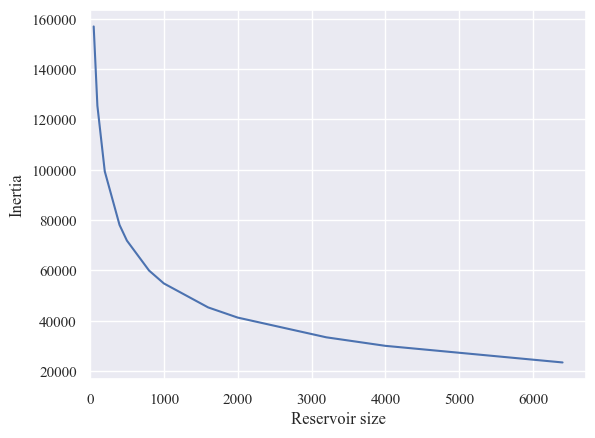

In [39]:
fig, axs = plt.subplots()
sns.lineplot(x=hidden_layer_sizes, y=inertias, markers=True)
axs.set_xlabel("Reservoir size")
axs.set_ylabel("Inertia")
axs.set_xlim((0, None))
plt.savefig(f"ellbow_curve_2048.pdf", bbox_inches='tight', pad_inches=0)